# Covid19 Analysis and Prediction for US
## by Tim Hickey on Mon 3/23/2020
In this jupyter notebook we take the current US covid-19 data from covidtracking.com
and plot it with a vertical log scale.  

As of 3/23/2020, the growth of the number of cases and deaths
were seen to be very nearly exponential with
deaths = 3.1 * 1.31^k  where k is the number of days after 3/3/2020

At this rate, by day 47 there will a million US deaths and everyone will be infected.
That is sometime in mid-April.

We will track these curves an predictions and hope that they change radically.

First we need to import some libraries

In [1]:
import math
import json
import numpy
import matplotlib.pyplot as plt
import requests
from datetime import date, timedelta

In [2]:
url = "https://covidtracking.com/api/us/daily"
text = requests.get(url).text
us_data = json.loads(text)
for d in us_data:
    d['dateChecked'] = d['date']
print(us_data[0])


{'date': 20200323, 'states': 56, 'positive': 42164, 'negative': 237321, 'posNeg': 279485, 'pending': 14571, 'hospitalized': 3325, 'death': 471, 'total': 294056, 'dateChecked': 20200323}


Next we read in the data from a file
We should modify this to read the data in from the online webservice
so it will be up to date...

In [3]:
with open('uscovid19.json') as f:
  data = json.load(f)
print(len(data))
print(data[0])
us_data.sort(key=lambda x: x['date'])
print(len(us_data))
us_data[0]
data = us_data


19
{'date': 20200304, 'states': 14, 'positive': 118, 'negative': 748, 'posNeg': 866, 'pending': 103, 'hospitalized': None, 'death': None, 'total': 969}
20


Now we clean up the data a bit (replace None values with 0)
and we get the values for the number of positive cases and the deaths
These are lists where the element at position k is the number of cases or deaths
on day k after 3/3/2020

In [4]:
def clean(n):
    if n==None:
        return 0
    else:
        return n

positives = [clean(x['positive']) for x in data]
deaths = [clean(x['death']) for x in data]
dates = [clean(x['date']) for x in data]
deaths

[0, 0, 0, 0, 0, 0, 0, 27, 36, 39, 49, 60, 71, 90, 112, 160, 219, 272, 398, 471]

We can now plot the data using matplotlib.pyplot which has been imported as plt

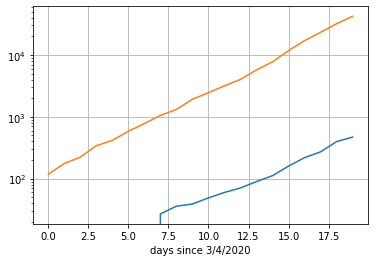

In [5]:
fig, ax = plt.subplots()
line1, = ax.plot(deaths)
line2, = ax.plot(positives)
plt.yscale('log')
plt.grid(True)
plt.xlabel('days since 3/4/2020')


plt.show()


Next we make a rough calculation of the average rate of increase per day over the past week to get the daily increase ratio for deaths and cases and we use it to see how accurately in predicts todays deaths/cases starting from a week ago.

In [6]:
# calulate d = death increase per day ratio
d_death = math.exp(math.log(deaths[-1]/deaths[-8])/7)
print(d_death)
print(deaths[-8:])
print(deaths[-8]*d_death**7)
n_death = len(deaths)

1.310372140847405
[71, 90, 112, 160, 219, 272, 398, 471]
470.99999999999983


In [7]:
# calulate d = death increase per day ratio
d_pos = math.exp(math.log(positives[-1]/positives[-8])/7)
print(d_pos)
print(positives[-8:])
print(round(positives[-8]*d_pos**7))
n_pos = len(positives)

1.3990459261549997
[4019, 5723, 7731, 11723, 17038, 23203, 31888, 42164]
42164


We can now start to make a prediction, since we have the daily rate of increase for deaths and cases. 
We also calculate the constant value to represent these as pure exponentials
``` python
f(k) = c * d**k
```


In [8]:
days=60
death_prediction = [round(deaths[-1]*d_death**(k-n_death+1)) for k in range(n_death,n_death+days)]
#print(death_prediction)
positive_prediction = [round(positives[-1]*d_pos**(k-n_pos+1)) for k in range(n_pos,n_pos+days)]
#print(positive_prediction)
c_pos = positives[-1]*d_pos**(1-n_pos)
print('c_pos',c_pos)
print('d_pos',d_pos)
c_death = deaths[-1]*d_death**(1-n_death)
print('c_death',c_death)
print('d_death',d_death)

c_pos 71.47173941116905
d_pos 1.3990459261549997
c_death 2.7702727769893682
d_death 1.310372140847405


Finally, we plot our predictions and also draw lines at on million, 330 million (the US population), and 7.53 billion (the world population)

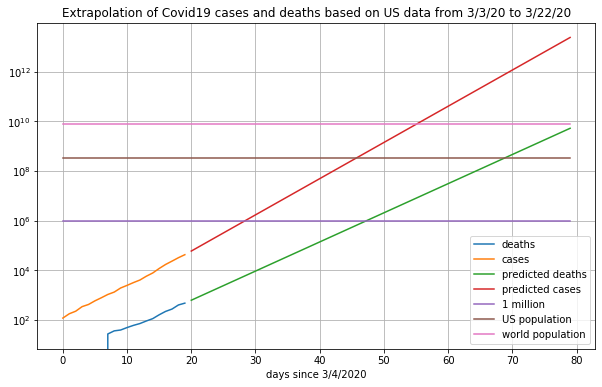

[10.0, 6.0]

In [9]:
plt.rcParams['figure.figsize'] = [10.0,6.0]
fig2, ax = plt.subplots()

line1, = ax.plot(deaths)
line2, = ax.plot(positives)
line3, = ax.plot(range(n_death,n_death+days),death_prediction)
line4, = ax.plot(range(n_pos,n_pos+days), positive_prediction)
line5, = ax.plot(range(0,n_pos+days),[1000000]*(n_pos+days))
line6, = ax.plot(range(0,n_pos+days),[330000000]*(n_pos+days))
line7, = ax.plot(range(0,n_pos+days),[7.53*10**9]*(n_pos+days))
# here we can plot our approximation of the deaths graph as a pure exponential function
#line8, = ax.plot(range(0,n_death+days),[c_death*d_death**k for k in range(0,n_pos+days)])
#line9, = ax.plot(range(0,n_pos+days),[c_pos*d_pos**k for k in range(0,n_pos+days)])
plt.yscale('log')
plt.grid(True)
plt.xlabel('days since 3/4/2020')
plt.legend(['deaths','cases','predicted deaths','predicted cases','1 million','US population','world population'])
plt.title("Extrapolation of Covid19 cases and deaths based on US data from 3/3/20 to 3/22/20")

plt.savefig('covid19.png')
plt.show()
plt.rcParams['figure.figsize']

# Milestones
Finally we use the exponential approxiation to see when we can expect large numbers of people to have died. This is assuming that we don't change policy and it ignores factors like herd immunity and the limited size of our population. It is just a straight extrapoloation from the exponential formula...

In [11]:
us_population = 330000000
def days_death(n):
   return math.log(n/c_death)/math.log(d_death)
def days_after(k):
    start = date(2020,3,4)
    return start+timedelta(days=k)

n_1e3 = round(days_death(1e3))
n_1e4 = round(days_death(1e4))
n_1e5 = round(days_death(1e5))
n_1e6 = round(days_death(1e6))
n_1e7 = round(days_death(1e7))
print('         1K dead in',n_1e3-len(data),'days on',days_after(n_1e3))
print('        10K dead in',n_1e4-len(data),'days on',days_after(n_1e4))
print('       100K dead in',n_1e5-len(data),'days on',days_after(n_1e5))
print('  1 million dead in',n_1e6-len(data),'days on',days_after(n_1e6))
print(' 10 million dead in',n_1e7-len(data),'days on',days_after(n_1e7))

         1K dead in 2 days on 2020-03-26
        10K dead in 10 days on 2020-04-03
       100K dead in 19 days on 2020-04-12
  1 million dead in 27 days on 2020-04-20
 10 million dead in 36 days on 2020-04-29
